In [1]:
import sys
sys.path.append('../')
import jax.numpy as jnp
import numpy as np

from attention import *
from utils import *

In [ ]:
n_in, n_out = 3, 2

x = jax.random.normal(jax.random.PRNGKey(0), (n_in,))
print(x.shape)

In [ ]:
context_len = 3
batch_size = 2
emb_size = 32
n_heads = 1
d_k = emb_size // n_heads

z = jnp.array(np.random.normal(size=(context_len, batch_size, emb_size)))
print(z.shape)
print(z.shape[:-1])
v = z.transpose(1, 0, 2)
print(v.shape)

preattn = PreAttention(emb_size=emb_size, n_heads=n_heads, d_k=d_k, bias=False)
rng = jax.random.PRNGKey(0)
state = preattn.init_state(rng)

q = preattn(state, z)
print(q.shape)

# scores borde vara (3, 3, 2, 1)

In [ ]:
s = jnp.einsum('ibhd,jbhd->ijbh', q, q)
print(s.shape)



In [ ]:
jnp.matmul(q, jnp.transpose(q, axes=(0, 1, 3, 2))).shape

In [ ]:
import torch
qt = torch.randn(size=(context_len, batch_size, n_heads, d_k))
kt = torch.randn(size=(context_len, batch_size, n_heads, d_k))

qt_1 = torch.einsum('ibhd,jbhd->ijbh', qt, kt)
print(qt_1.shape)

qt_2 = jnp.einsum('ibhd,jbhd->ijbh', qt.detach().numpy(), kt.detach().numpy(), optimize='optimal')
print(qt_2.shape)

allclose = np.allclose(qt_1.detach().numpy(), qt_2)
print(allclose)

In [ ]:
qtj = qt.detach().numpy()
ktj = kt.detach().numpy()

res = jnp.einsum("...id,...jd->...ij", qtj, ktj)
print(res.shape)

# Example 2: do the same operation using matmul

res2 = jnp.matmul(qtj, ktj.transpose(0, 1, 3, 2))

print(res2.shape)

allclose = np.allclose(res, res2)
print(allclose)


In [ ]:
res3 = jnp.einsum("cbhd,Cbhd->cCbh", qtj, ktj)
print(res3.shape)

In [ ]:
# Transposing a matrix is just dimension permutation

x = np.random.normal(size=(2, 3))
print(x)
print(x.transpose(1, 0))

In [ ]:
v = np.random.normal(size=(1, 3))
jnp.einsum('ij,kj->ik', x, v)

In [ ]:
x = np.random.normal(size=(2, 2))
# Matrix matrix
print(jnp.einsum('ij,kj->ik', x, x))
print(x @ x.T)
print(jnp.einsum('ik,kj->ij', x, x))

In [ ]:
from attention import softmax
r = 0
x = np.random.normal(size=(2, 2))
print(x)
xs = softmax(x, dim=r)
print(xs)
print(sum(xs, 0))

In [ ]:
context_len = 3
batch_size = 16
n_heads = 4

single_mask = jnp.tril(jnp.ones((context_len, context_len)), k=0)
print(single_mask)

attention_weights = jax.random.normal(jax.random.PRNGKey(0), (context_len, context_len))
print(attention_weights)

filled = jnp.where(single_mask == 0, float('-inf'), attention_weights)
print(filled)

softmaxed = softmax(filled, dim=-1)
print(softmaxed)

In [ ]:
# (context_len, context_len, batch_size, n_heads)

single_mask = jnp.tril(jnp.ones((context_len, context_len)), k=0)
print(f"single_mask: {single_mask.shape}")
# expand last dim twice
single_mask = jnp.expand_dims(single_mask, axis=-1)
single_mask = jnp.expand_dims(single_mask, axis=-1)
print(f"single_mask: {single_mask.shape}")

batch_mask = jnp.repeat(single_mask, batch_size, axis=2)
print(f"batch_mask: {batch_mask.shape}")

head_mask = jnp.repeat(batch_mask, n_heads, axis=3)
print(f"head_mask: {head_mask.shape}")



In [ ]:
single_mask = jnp.tril(jnp.ones((context_len, context_len)), k=0)
single_mask = single_mask.reshape((context_len, context_len, 1, 1))
mask = jnp.tile(single_mask, (1, 1, batch_size, n_heads))
print(mask.shape)

In [ ]:
##### COMPARE MHA MASK #####

context_len = 2
batch_size = 1
emb_size = 1
n_heads = 1

# should be of size (context_len, context_len)
import torch
torch_mask = torch.tril(torch.ones((context_len, context_len)), diagonal=0)
print(torch_mask.numpy())

torch_mha = torch.nn.MultiheadAttention(emb_size, n_heads, bias=False)

torch_x = torch.randn(size=(context_len, batch_size, emb_size))
print(f"input: {torch_x}, shape: {torch_x.shape}")
with torch.no_grad():
    torch_res, torch_weights = torch_mha(torch_x, torch_x, torch_x, attn_mask=torch_mask.T)
print(torch_res.shape)
print(f"Output: {torch_res.numpy()}")

In [ ]:
# print all weighs of torch_attn
jax_mha_state = to_jax_state(torch_mha)

In [ ]:
x = jnp.array(torch_x.numpy())
print(f"Input: {x}, shape: {x.shape}")

attn = MultiHeadAttention(emb_size=emb_size, n_heads=n_heads, v_bias=False)

mask = attn.get_causal_mask(context_len, batch_size)
print(f"mask.shape: {mask.shape}")
print(mask[:,:, 0, 0])

res = attn(jax_mha_state, x, x, x, mask)
print(f"out.shape: {res.shape}")
print(res)

print(f"Mask close: {np.allclose(torch_mask.numpy(), mask[:,:, 0, 0])}")
print(f"Output Close: {np.allclose(torch_res.numpy(), res, atol=1e-5)}")

# Not getting masked outputs to match...

In [ ]:
from act import dropout
import jax
x = torch.randn(4, 2, 3, requires_grad=False)

In [ ]:
x_jnp = jnp.array(x.numpy())
torch.manual_seed(0)
rng = jax.random.PRNGKey(0)
y_jnp = dropout(x_jnp, 0.5, rng, training=True)
print(y_jnp)

y_torch = torch.nn.functional.dropout(x, 0.5, training=True)
print(y_torch)

In [9]:
from torch import Tensor, nn
import torch
import math
import matplotlib.pyplot as plt

class PositionalEncodingTorch(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        print(f"position.shape: {position.shape}")
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        print(f"div_term.shape: {div_term.shape}")
        pe = torch.zeros(max_len, 1, d_model)
        print(f"pe.shape: {pe.shape}")
        m = position * div_term
        print(f"m.shape: {m.shape}")
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        print(f"pe.shape: {pe.shape}")
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        print(f"x.size: {x.size(0)}")
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

x_shape = (100, 1, 512)
x_torch = torch.randn(x_shape)

In [17]:
pos_torch = PositionalEncodingTorch(d_model=x_shape[2], dropout=0)

position.shape: torch.Size([5000, 1])
div_term.shape: torch.Size([256])
pe.shape: torch.Size([5000, 1, 512])
m.shape: torch.Size([5000, 256])
pe.shape: torch.Size([5000, 1, 512])


In [18]:
print(f"input.shape: {x_torch.shape}")
y_torch = pos_torch(x_torch)
print(f"output.shape: {y_torch.shape}")

input.shape: torch.Size([100, 1, 512])
x.size: 100
output.shape: torch.Size([100, 1, 512])


x.size: 100


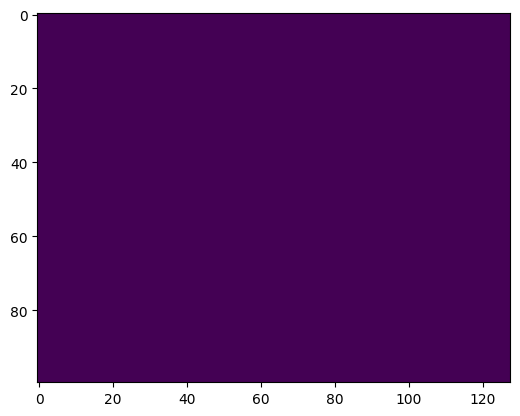

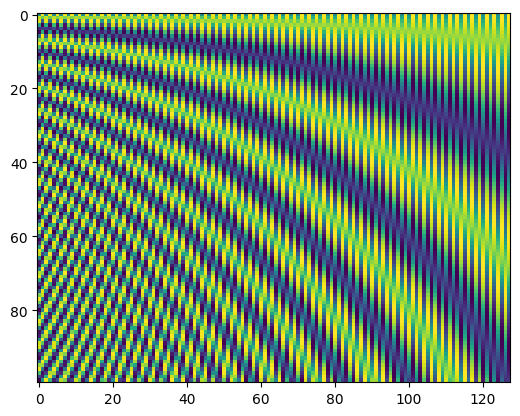

In [19]:
x2 = torch.zeros(x_shape)
plt.figure()
plt.imshow(x2[:, 0, :128].numpy());
y2 = pos_torch(x2)
plt.figure()
plt.imshow(y2[:, 0, :128].numpy());

In [6]:
x = jax.random.normal(jax.random.PRNGKey(0), (10, 512))
print(x.shape)
from act import dropout

class PositionalEncoding:
    def __init__(self, emb_size: int, dropout_prob: float=0, max_len: int=5000):
        self.emb_size = emb_size
        self.dropout_prob = dropout_prob
        self.max_len = max_len

        self.embeds = self._create_embeds()
        
    def _create_embeds(self):
        # create embeds which is broadcastable with input x
        position = jnp.arange(self.max_len)
        position = jnp.expand_dims(position, axis=1)

        div_term = jnp.exp(jnp.arange(0, self.emb_size, 2) * (-jnp.log(10000.0) / self.emb_size))
        pe = jnp.zeros((self.max_len, 1, self.emb_size))
        pe = pe.at[:, 0, 0::2].set(jnp.sin(position * div_term))
        pe = pe.at[:, 0, 1::2].set(jnp.cos(position * div_term))
        return pe

    def __call__(self, x: jax.Array, rng: jax.Array, training: bool=True) -> Tuple[jax.Array, jax.Array]:
        # x.shape: (context_len, batch_size, embed_dim)
        assert len(x.shape) == 3
        print(x.shape)
        x = x + self.embeds[:x.shape[0]]
        return dropout(x, self.dropout_prob, rng, training=training)
        

(10, 512)


(5000, 1, 512)
x.shape: (100, 1, 512)
(100, 1, 512)
mask: [[[ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]]

 ...

 [[ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]]]
y.shape: (100, 1, 512)


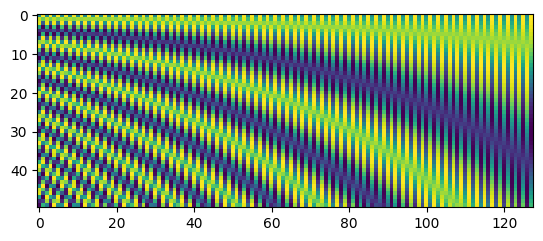

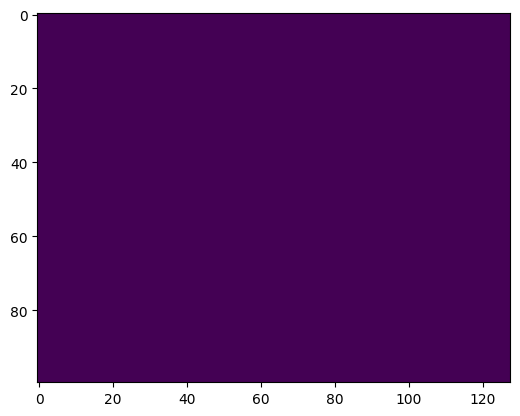

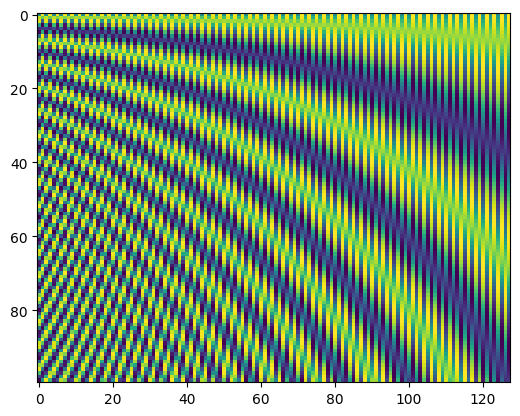

In [20]:
rng = jax.random.PRNGKey(0)
pos = PositionalEncoding(emb_size=512, dropout_prob=0.0, max_len=5000)
plt.figure()
plt.imshow(pos.embeds[:50, 0, :128])
# x = jax.random.normal(rng, (10, 1, 512))
x = jnp.zeros((100, 1, 512))
print(pos.embeds.shape)
print(f"x.shape: {x.shape}")
plt.figure()
plt.imshow(x[:, 0, :128])
y, rng = pos(x, rng, training=True)
print(f"y.shape: {y.shape}")
plt.figure()
plt.imshow(y[:, 0, :128])